In [1]:
import os
import caesar
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import modules as anal
import modules.anal_func as anal_func

from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.io import fits
from scipy import interpolate


cosmo = LambdaCDM(H0 = 68, Om0= 0.3, Ode0= 0.7, Ob0=0.048)
plt.rcParams.update({'font.size': 28})

In [2]:
# initialize the Simba class, which import the needed paths
sb = anal.Simba('PC39BP4', size=100)
# initialize the SavePaths class to create destinations
sv = anal.SavePaths() 
pltsv  = sv.get_filetype_path('plot')
scatter = sv.create_subdir(pltsv, 'scatter')

In [3]:
# I will work with a single snapshot for now
snap = 129
cs = sb.get_caesar(snap)
a = cs.simulation.scale_factor
z = sb.get_redshifts()
clust_mass_thresh = 1e14

yt : [INFO     ] 2024-08-14 09:38:36,830 Opening /media/lorenzong/Data1/SIMBA_catalogs/m100n1024_129.hdf5
yt : [INFO     ] 2024-08-14 09:38:37,287 Found 495012 halos
yt : [INFO     ] 2024-08-14 09:38:37,428 Found 46575 galaxies


In [4]:
# We want all central galaxies in clusters
central_gal_ind = np.asarray([i.GroupID for i in cs.galaxies if i.central==1]) # select central galaxies
print('Total number of central galaxies: ', len(central_gal_ind))
gals_in_clusters = [i.galaxy_index_list for i in cs.halos if i.masses['total']>clust_mass_thresh] # galaxies in masive halos
gals_in_clusters = np.concatenate(gals_in_clusters)
print(f'Total number of Mtot above {clust_mass_thresh} Msun: ', len(gals_in_clusters))
central_in_cluster_id = central_gal_ind[np.isin(central_gal_ind, gals_in_clusters)]
print('Total number of central galaxies in clusters: ', len(central_in_cluster_id))

Total number of central galaxies:  30429
Total number of Mtot above 100000000000000.0 Msun:  2363
Total number of central galaxies in clusters:  24


In [5]:
# Now that we have filtered the needed galaxies we can study their properties
Ms      = np.asarray([i.masses['stellar'] for i in cs.galaxies])[central_in_cluster_id]
Mh2     = np.asarray([i.masses['H2'] for i in cs.galaxies])[central_in_cluster_id]
Mh1     = np.asarray([i.masses['HI'] for i in cs.galaxies])[central_in_cluster_id]
Md      = np.asarray([i.masses['dust'] for i in cs.galaxies])[central_in_cluster_id]
sfr     = np.asarray([i.sfr for i in cs.galaxies])[central_in_cluster_id]
ages    = np.asarray([i.ages['mass_weighted'] for i in cs.galaxies])[central_in_cluster_id]
bh_fedd = np.asarray([i.bh_fedd for i in cs.galaxies])[central_in_cluster_id]
bh_mass = np.asarray([i.masses['bh'] for i in cs.galaxies])[central_in_cluster_id]
met     = np.asarray([i.metallicities['mass_weighted'] for i in cs.galaxies])[central_in_cluster_id]
met_cgm = np.asarray([i.metallicities['mass_weighted_cgm'] for i in cs.galaxies])[central_in_cluster_id]
T       = np.asarray([i.temperatures['mass_weighted'] for i in cs.galaxies])[central_in_cluster_id]
T_cgm   = np.asarray([i.temperatures['mass_weighted_cgm'] for i in cs.galaxies])[central_in_cluster_id]

In [6]:
# we want also the info on the corresponding halos
Mhalo      = np.asarray([i.halo.masses['total'] for i in cs.galaxies])[central_in_cluster_id]
Mhalo_h2   = np.asarray([i.halo.masses['H2'] for i in cs.galaxies])[central_in_cluster_id] - Mh2
Mhalo_h1   = np.asarray([i.halo.masses['HI'] for i in cs.galaxies])[central_in_cluster_id] - Mh1
Mhalo_dust = np.asarray([i.halo.masses['dust'] for i in cs.galaxies])[central_in_cluster_id]-Md
methalo    = np.asarray([i.halo.metallicities['mass_weighted'] for i in cs.galaxies])[central_in_cluster_id]
Tvir       = np.asarray([i.halo.virial_quantities['temperature'] for i in cs.galaxies])[central_in_cluster_id]

In [7]:
# calculate oxygen abundance and DTM
logoh12 = anal_func.Z_to_OH12(met)
logoh12_h = anal_func.Z_to_OH12(methalo)
dtm     = anal_func.Dust_to_Metal(Md, Mh2, logoh12)

In [8]:
# Let's see how many satellites there are for each galaxy:
from modules.anal_func.side_functions.search import findsatellites
r = 50
pos = np.asarray([i.pos for i in cs.galaxies])
sat_ids = findsatellites(pos, sb, snap, r)

yt : [INFO     ] 2024-08-14 09:38:48,947 Opening /media/lorenzong/Data1/SIMBA_catalogs/m100n1024_129.hdf5
yt : [INFO     ] 2024-08-14 09:38:48,955 Found 495012 halos
yt : [INFO     ] 2024-08-14 09:38:48,958 Found 46575 galaxies


In [ ]:
# DGR vs Mhalo colored with metallicity (black points are those with no dust at all)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nodust = Md == 0
sc = ax.scatter(np.log10(Mhalo), np.log10(Md / Mh2), c=logoh12, s=100)
ax.scatter(np.log10(Mhalo)[nodust], -6.5*np.ones(len(Ms[nodust])), c='k', s=100)
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm O/H)+12$')
ax.set_xlabel(r'$\log(M_{\rm halo}/M_{\odot})$')
ax.set_ylabel(r'$\log(M_{\rm dust}/M_{\rm H_2})$')
fig.savefig(os.path.join(scatter, 'DGR_Mhalo_met.png'), bbox_inches = 'tight')

In [ ]:
# DGR vs Mhalo colore with fraction of dust in the halo wrt in the satellites around the central (distance r)
nsat = np.asarray([len(sat_ids[i]) for i in sat_ids])
Md_tot      = np.asarray([i.masses['dust'] for i in cs.galaxies])
Ms_tot      = np.asarray([i.masses['stellar'] for i in cs.galaxies])
dustsat = np.asarray([sum(Md_tot[sat_ids[i]]) for i in sat_ids])
masssat = np.asarray([sum(Ms_tot[sat_ids[i]]) for i in sat_ids])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sc = ax.scatter(np.log10(Mhalo), np.log10(Md/Mh2), c=Mhalo_dust/dustsat, norm=colors.LogNorm(), s=100)
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$M_{\rm dust, halo}/M_{\rm dust, satell.}$')
ax.set_xlabel(r'$\log(M_{\star}/M_{\odot})$')
ax.set_ylabel(r'$\log(M_{\rm dust}/M_{\rm H_2})$')
fig.savefig(os.path.join(scatter, 'DGR_Mhalo_dustinhalo.png'), bbox_inches = 'tight')

In [ ]:
# Comparison with dust/star in the satellites around the central (at distance r) vs the fraction of dust diffused in the halo (so not in galaxies)
# colored with the dust fraction i n the central
# The size represents the number of satellites
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
minreplace = dustsat[dustsat!=0].min()-0.3*dustsat[dustsat!=0].min()
#dustsat[dustsat==0] = minreplace #pay attention here: run cell only once
#ax.axhline(np.log10(minreplace), ls='--', c='r')
sc = plt.scatter(np.log10(Mhalo_dust/Mhalo), np.log10(dustsat/Ms), c=Md/Ms, s=nsat*20, norm=colors.LogNorm())
cbar = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$M_{\rm dust, central}/M_{\star}$')
ax.set_xlabel(r'$\log(M_{\rm dust, halo}/M_{\rm tot})$')
ax.set_ylabel(r'$\log(M_{\rm dust, satell.}/M_{\rm central})$')
ax.set_title(f'Satellites in r={r} kpc')
plt.legend(*sc.legend_elements("sizes", num=6, func=lambda x: x/20))
fig.savefig(os.path.join(scatter, 'dust_sat_halo_cent.png'), bbox_inches = 'tight')

In [9]:
# from modules.anal_func.filter_particles import copy_skeleton, filter_particles_by_obj
# sb = anal.Simba('PC39BP4', size=25)
# filter_particles_by_obj(cs, sb.get_sim_file(snap), snap, 'galaxy', [0,1], verbose=0, overwrite=True, ignore_fields=[], keyword=None)

Finished with particle filters


In [2]:
from modules.anal_func.read_progenitors import read_progen
sb = anal.Simba('PC39BP4', size=100)
cs = sb.get_caesar(150)
totids = np.asarray([i.GroupID for i in cs.galaxies])
read_progen(totids, 'progenitors_most_mass_nocaesar.fits', np.arange(44, 150, 1).astype(int), sb, '/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5')

yt : [INFO     ] 2024-08-15 13:47:11,995 Opening /media/lorenzong/Data1/SIMBA_catalogs/m100n1024_150.hdf5
yt : [INFO     ] 2024-08-15 13:47:12,017 Found 465211 halos
yt : [INFO     ] 2024-08-15 13:47:12,058 Found 55336 galaxies


Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_149.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_148.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_147.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_146.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_145.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_144.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_143.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_142.fits
Processing current snap: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_141.fits
Processing

In [17]:
# check that the tree_data are saved correctly
import h5py
for i in range(40, 150):
    with fits.open(f'/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_{i:03}.fits') as f:
        a = f[1].data['descend_galaxy_star']
    
    with h5py.File(sb.get_caesar_file(i)) as h5:
        b = np.asarray(h5['tree_data']['progen_galaxy_star'][:,0])
    
    if sum(a-b) >0:
        print(f'File {i:03} is wrong!')

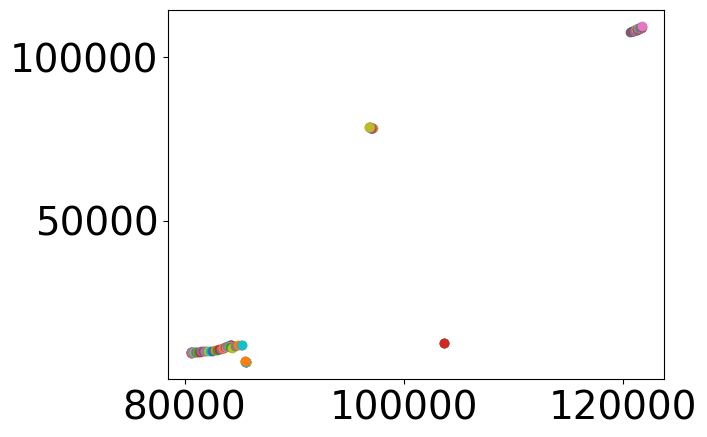

In [19]:
# If this is the same as the following cell means that at least the translation from hdf5 to fits is correct
plt.figure()
for i in range(40, 150):
    with fits.open(f'/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_{i:03}.fits') as f:
        myd = f[1].data['GroupID'] == 0
        plt.scatter(f[1].data['pos_0'][myd], f[1].data['pos_1'][myd])

In [3]:
# This is what happens if I just trace a single index in all original files
import h5py
plt.figure()
for i in range(40, 151)[::-1]:
    with h5py.File(f'/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_{i:03}.hdf5') as f:
        print(f'/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_{i:03}.hdf5')
        tree = np.asarray(f['tree_data']['progen_galaxy_star'])
        # myd = np.asarray(f['galaxy_data']['GroupID']) == 0
        # print('group')
        # print(np.asarray(f['galaxy_data']['GroupID'])[:10])
        # print('tree')
        # print(tree[:10,0])
        # print('is any?: ', tree[tree==-1])
        # x = np.asarray(f['galaxy_data']['pos'][:,0][myd])
        # y = np.asarray(f['galaxy_data']['pos'][:,1][myd])
        # plt.scatter(x, y)
        print('try: ', len(tree[:,0][tree[:,0]==0]))
        print(tree.shape)
        print('len -1: ', len(tree[:,0][tree[:,0]==-1]))

/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_150.hdf5
try:  244
(55336, 2)
len -1:  1386
/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_149.hdf5
try:  248
(55061, 2)
len -1:  1413
/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_148.hdf5
try:  241
(54406, 2)
len -1:  1382
/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_147.hdf5
try:  27
(54032, 2)
len -1:  1399
/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_146.hdf5
try:  29
(53653, 2)
len -1:  1414
/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_145.hdf5
try:  21
(53121, 2)
len -1:  1378
/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_144.hdf5
try:  29
(52724, 2)
len -1:  1461
/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_143.hdf5
try:  35
(52334, 2)
len -1:  1352
/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_142.hdf5
try:  254
(51954, 2)
len -1:  1383
/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_141.hdf5
try:  18
(51450, 2)
len -1:  1445
/media/lorenzong/Data1/SIMBA_catalogs/m100n1024_140.hdf5
try:  23
(51040, 2)
len -1:  

<Figure size 640x480 with 0 Axes>

In [ ]:
with fits.open('/home/lorenzong/analize_simba_cgm/output/fits/progenitors_files/progenitors_most_mass_nocaesar.fits') as f:
    print(f[1].data.columns.names)
    # col_names = f[1].data.columns.names
    # #start_col_index = col_names.index(str(100))
    # #end_col_index = col_names.index(str(149))
    # print(f[1].data['130'][:100])
    print(f[1].data[0])

In [5]:
import os
import caesar
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import modules as anal
import modules.anal_func as anal_func

from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.io import fits
from scipy import interpolate

cosmo = LambdaCDM(H0 = 68, Om0= 0.3, Ode0= 0.7, Ob0=0.048)
plt.rcParams.update({'font.size': 28})

# initialize the Simba class, which import the needed paths
sb = anal.Simba('PC39BP4', size=100)
# initialize the SavePaths class to create destinations
sv = anal.SavePaths() 
pltsv  = sv.get_filetype_path('plot')
scatter = sv.create_subdir(pltsv, 'scatter')

In [8]:
from modules.anal_func.build_history import BuildHistory
from modules.anal_func.read_progenitors import read_progen
sb = anal.Simba('PC39BP4', size=100)
cs = sb.get_caesar(150)
totids = np.asarray([i.GroupID for i in cs.galaxies])
sb = anal.Simba('PC39BP4', size=100)
sfh = BuildHistory(sb, '/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5', progfilename='progenitors_most_mass_nocaesar.fits')

yt : [INFO     ] 2024-08-15 14:16:26,231 Opening /media/lorenzong/Data1/SIMBA_catalogs/m100n1024_150.hdf5
yt : [INFO     ] 2024-08-15 14:16:27,066 Found 465211 halos
yt : [INFO     ] 2024-08-15 14:16:27,937 Found 55336 galaxies


In [14]:
hist = sfh.get_history_indx([10], start_snap=44, end_snap=149)

In [10]:
print(hist) 

{0: {'44': 6, '45': 7, '46': 8, '47': 6, '48': 6, '49': 6, '50': 6, '51': 6, '52': 6, '53': 5, '54': 5, '55': 5, '56': 4, '57': 4, '58': 4, '59': 4, '60': 4, '61': 4, '62': 4, '63': 4, '64': 4, '65': 4, '66': 6, '67': 7, '68': 6, '69': 0, '70': 0, '71': 0, '72': 0, '73': 0, '74': 0, '75': 0, '76': 0, '77': 0, '78': 0, '79': 0, '80': 0, '81': 0, '82': 0, '83': 0, '84': 0, '85': 0, '86': 0, '87': 0, '88': 0, '89': 0, '90': 0, '91': 0, '92': 0, '93': 0, '94': 0, '95': 1, '96': 0, '97': 0, '98': 0, '99': 1, '100': 1, '101': 0, '102': 1, '103': 1, '104': 1, '105': 0, '106': 0, '107': 0, '108': 0, '109': 0, '110': 0, '111': 0, '112': 0, '113': 0, '114': 1, '115': 1, '116': 0, '117': 1, '118': 1, '119': 1, '120': 1, '121': 1, '122': 0, '123': 1, '124': 1, '125': 1, '126': 1, '127': 1, '128': 0, '129': 1, '130': 1, '131': 1, '132': 1, '133': 1, '134': 1, '135': 1, '136': 1, '137': 0, '138': 1, '139': 1, '140': 1, '141': 0, '142': 1, '143': 1, '144': 1, '145': 1, '146': 1, '147': 0, '148': 0, '

In [15]:
sfr = sfh.get_property_history(['pos_0', 'pos_1', 'stellar_masses', 'sfr', 'GroupID'])

In [12]:
print(sfr['GroupID'])

{0: [6.0, 7.0, 8.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0, 7.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 1: [128.0, 201.0, 203.0, 124.0, 106.0, 101.0, 93.0, 82.0, 75.0, 75.0, 70.0, 72.0, 72.0, 70.0, 57.0, 23.0, 20.0, 20.0, 18.0, 16.0, 17.0, 16.0, 12.0, 17.0, 14.0, 12.0, 8.0, 8.0, 6.0, 5.0, 5.0, 5.0, 3.0, 4.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0

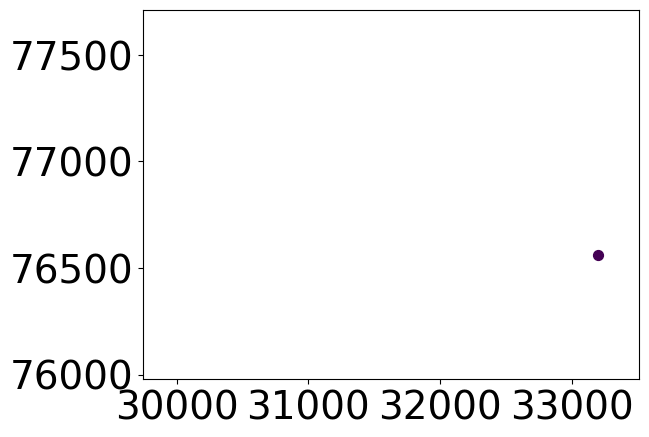

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def dict_to_2d_array(data, fill_value=np.nan):
    """
    Converts a dictionary of lists into a 2D NumPy array.
    
    Parameters:
    - data: dict, where each key is associated with a list of numerical values
    - fill_value: value to fill in for shorter lists (default: np.nan)
    
    Returns:
    - 2D NumPy array where each row corresponds to a dictionary key's list.
    """
    # Determine the maximum length of the lists
    max_length = max(len(lst) for lst in data.values())

    # Create a 2D array with shape (number of keys, max_length)
    array_2d = np.full((len(data), max_length), fill_value)

    # Fill the array with the dictionary values
    for i, (key, values) in enumerate(data.items()):
        array_2d[i, :len(values)] = values

    return array_2d

def create_animation(x, y):
    """
    Creates an animated scatter plot.

    Parameters:
    - x: 2D NumPy array for x-coordinates
    - y: 2D NumPy array for y-coordinates
    """
    # Create figure and axis
    fig, ax = plt.subplots()
    scat = ax.scatter([], [], s=50)  # Initialize empty scatter plot

    # Set axis limits based on the data
    min_x, max_x = np.nanmin(x), np.nanmax(x)
    min_y, max_y = np.nanmin(y), np.nanmax(y)
    margin = 0.1 * (max_x - min_x)  # Add some margin to the plot
    ax.set_xlim(min_x - margin, max_x + margin)
    ax.set_ylim(min_y - margin, max_y + margin)

    # Function to update the animation
    def update(frame):
        # Select the positions for the current snapshot
        current_x = x[:, frame]
        current_y = y[:, frame]

        # Set the colors and alpha values
        colors = plt.cm.viridis(np.linspace(0, 1, len(current_x)))

        # Update the scatter plot with the current positions
        scat.set_offsets(np.column_stack((current_x, current_y)))
        scat.set_color(colors)

        return scat,

    # Create animation
    ani = FuncAnimation(fig, update, frames=x.shape[1], interval=3000, repeat=True)

    # Save the animation as a GIF or MP4 file
    ani.save("animation.gif", writer=PillowWriter(fps=5))  # For GIF
    # ani.save("animation.mp4", writer='ffmpeg')  # Uncomment this line to save as MP4

    # Display the plot
    plt.show()

# Example usage
x = dict_to_2d_array(sfr['pos_0'])
y = dict_to_2d_array(sfr['pos_1'])

create_animation(x, y)


MovieWriter ffmpeg unavailable; using Pillow instead.


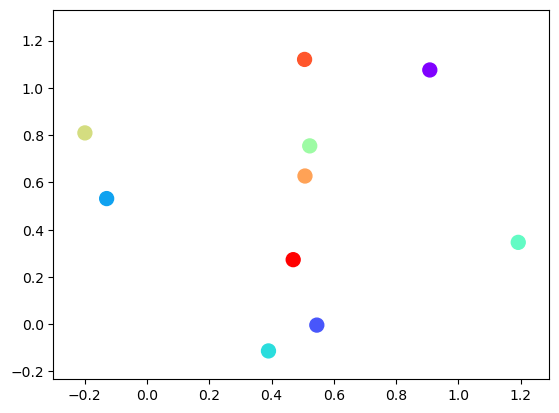

In [3]:

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from celluloid import Camera
 
numpoints = 10
points = np.random.random((2, numpoints))
colors = cm.rainbow(np.linspace(0, 1, numpoints))
camera = Camera(plt.figure())
for _ in range(100):
    points += 0.1 * (np.random.random((2, numpoints)) - .5)
    plt.scatter(*points, c=colors, s=100)
    camera.snap()
anim = camera.animate(blit=True)
anim.save('scatter.gif')

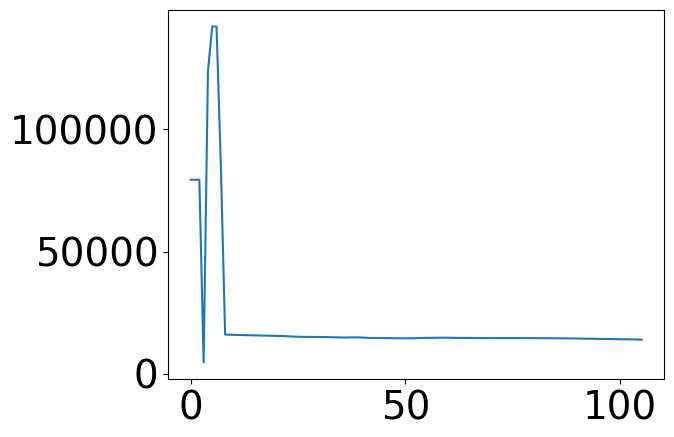

In [23]:
plt.plot(sfr['pos_0'][4])

In [11]:
sfh.plot_history([0], cosmo, interpolate=None)

IndexError: list index out of range

In [20]:
sfr

({'Redshift': array([1.14547155, 1.11382975, 1.08274756, 1.05220819, 1.02219971,
         0.99269876, 0.96369906, 0.93517924, 0.90713403, 0.87954028,
         0.85239043, 0.8256704 , 0.79936699, 0.77346787, 0.74796451,
         0.72284581, 0.6980956 , 0.6737074 , 0.64967231, 0.62597661,
         0.6026129 , 0.57956923, 0.55683944, 0.53441306, 0.51228049,
         0.49043515, 0.4688688 , 0.44757185, 0.42653759, 0.40575799,
         0.38522574, 0.3649343 , 0.34487597, 0.32504386, 0.30543191,
         0.28603304, 0.26684268, 0.24785214, 0.22905688, 0.21045153,
         0.19202867, 0.1737847 , 0.15571264, 0.13780788, 0.12006417,
         0.10247871, 0.0850459 , 0.06776006, 0.05061772, 0.03361203,
         0.01674167])},
 {'sfr': array([0.00000000e+00, 8.06786346e+01, 1.65693551e-01, 0.00000000e+00,
         7.94292271e-01, 2.22760353e+01, 2.11996473e-02, 5.84383346e-02,
         4.78457101e-02, 0.00000000e+00, 1.16725806e-02, 5.09378254e-01,
         3.48187760e-02, 3.30987602e-01, 2.16653

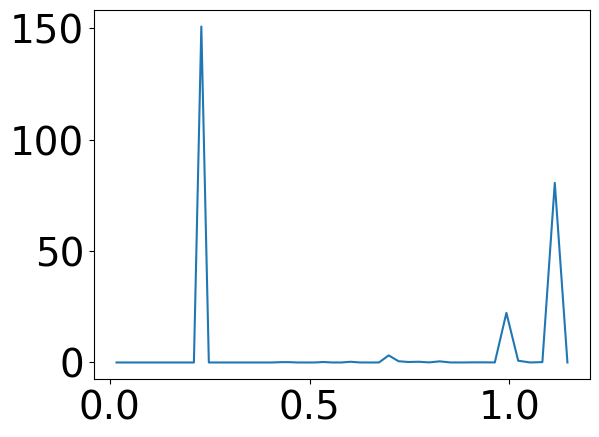

In [22]:
plt.plot(sfr[0]['Redshift'], sfr[1]['sfr'])
#plt.yscale('log')

In [5]:
from modules.data_objects.convert_hdf5_fits import *
from astropy.io import fits

In [6]:
sb = anal.Simba('PC39BP4', size=100)
convert_hdf5_fits(sb, range(115,117), ignore = ['mag', 'list'],verbose=1)

Processing : /media/lorenzong/Data1/SIMBA_catalogs/m100n1024_115.hdf5
Saved fits in: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_115.fits
Processing : /media/lorenzong/Data1/SIMBA_catalogs/m100n1024_116.hdf5
Saved fits in: /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_116.fits


In [7]:
a = sb.get_caesar_file(140)

In [9]:
import h5py
with h5py.File(a) as f:
    b = f['tree_data']
    print(b.keys())

<KeysViewHDF5 ['descend_galaxy_star', 'progen_galaxy_star', 'progen_halo_dm']>


/tmp/ipykernel_135153/1369735307.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 100)  # '11' should match the number of files or categories you have


Error processing file /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_116.fits: "Key 'pos_0' does not exist."
Error processing file /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_117.fits: [Errno 2] No such file or directory: '/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_117.fits'
Error processing file /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_118.fits: [Errno 2] No such file or directory: '/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_118.fits'
Error processing file /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_119.fits: [Errno 2] No such file or directory: '/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_119.fits'
Error processing file /home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_120.fits: [Errno 2] No such file or directory: '/home/lorenzong/anal

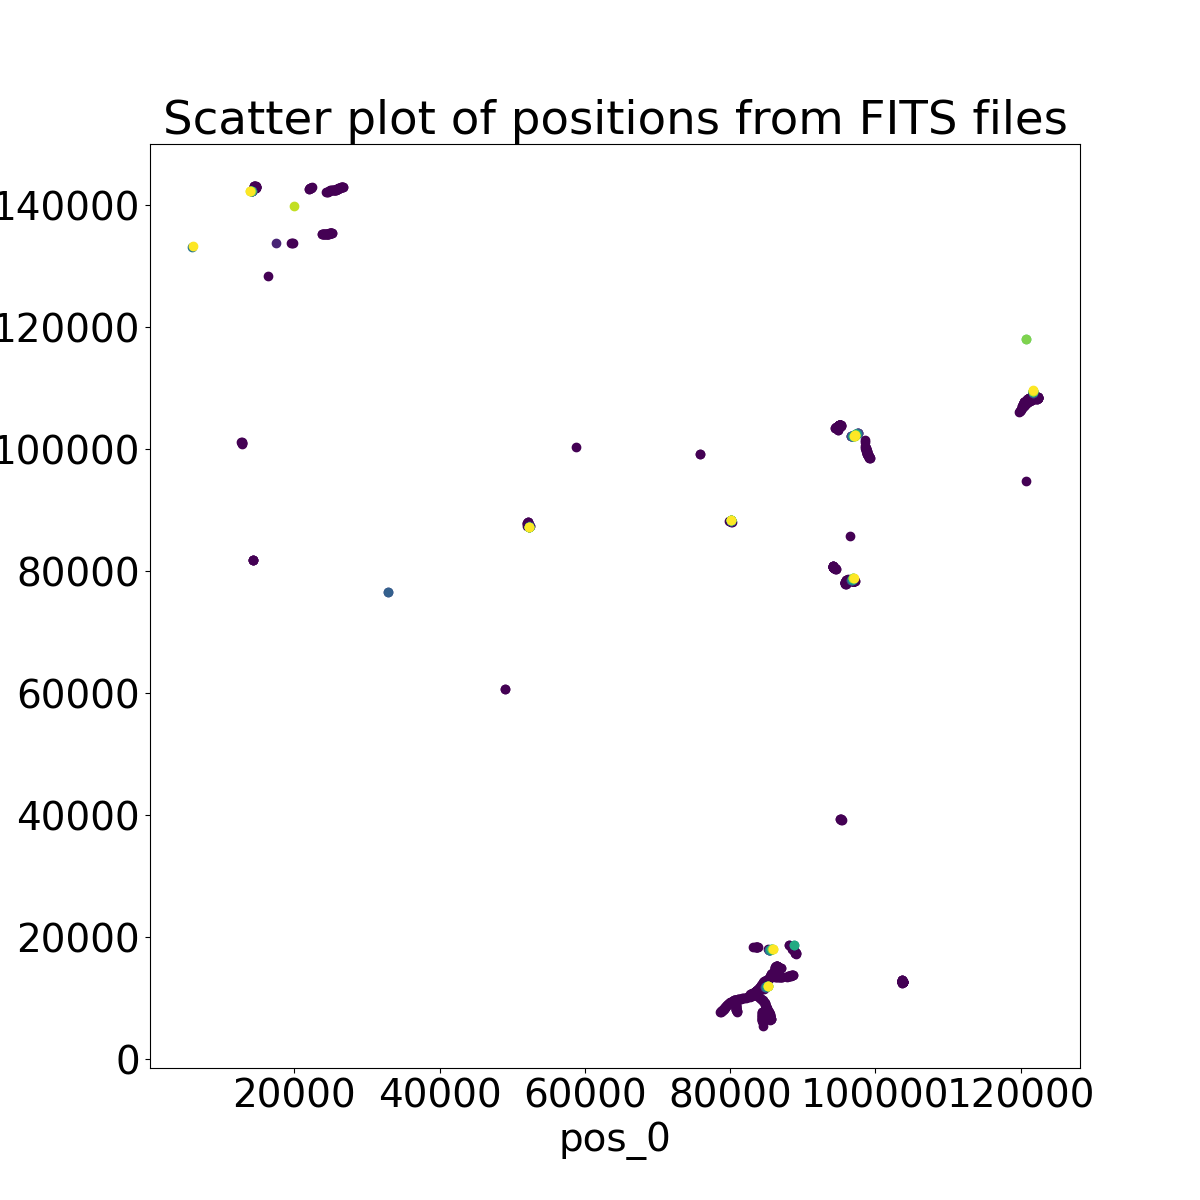

In [9]:
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.cm as cm

# Use interactive backend
%matplotlib widget

# Define the colormap
cmap = cm.get_cmap('viridis', 100)  # '11' should match the number of files or categories you have

# Create the figure
fig, ax = plt.subplots(figsize=(12, 12))

# Iterate over the FITS files
for i in range(40, 151):
    file_path = f'/home/lorenzong/analize_simba_cgm/output/fits/converted_from_hdf5/m100n1024_{i:03}.fits'
    try:
        with fits.open(file_path) as fi:
            d = fi[1].data
            # Calculate color based on the index
            color = cmap((i - 140) / 10.0)  # (i - 140) maps index to range [0, 1]
            ax.scatter(d['pos_0'][:10], d['pos_1'][:10], color=color)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Add labels and title
ax.set_xlabel('pos_0')
ax.set_ylabel('pos_1')
ax.set_title('Scatter plot of positions from FITS files')

# Show the interactive plot
plt.show()



In [8]:
a = np.array([67, 9, 0, 23, 66, 78, 33, 21])
b = [3, 1, 5]
print(a[b])

[23  9 78]
